In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..'))
from scripts.augment import insert_image

from IPython.display import clear_output
clear_output()

In [ ]:
PCB_DIR = os.path.join('..', 'data', 'cropped_pcbs')
BACKGROUND_DIR = os.path.join('..', 'data', 'backgrounds')
DISTRACTIONS_DIR = os.path.join('..', 'data', 'distractions')
AUGMENTED_OBB_DIR = os.path.join('..', 'data', 'augmented_obb')
AUGMENTED_SEG_DIR = os.path.join('..', 'data', 'augmented_seg')

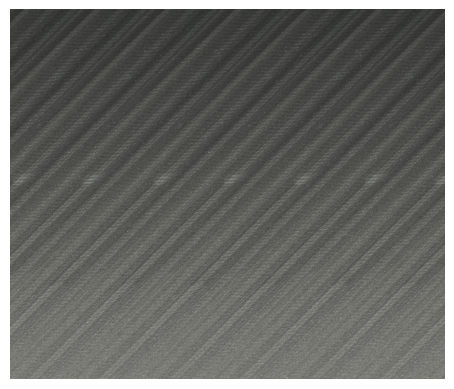

In [150]:
background_images = [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) if f.endswith('.png')]
def get_random_background(min_size=2000, max_size=4000):
    """
    Get a random background image with random dimensions.
    It is randomly a color or an image from the BACKGROUND_DIR.
    """
    shape = np.random.randint(min_size, max_size, size=2)
    if np.random.rand() < 0.3:
        color = np.random.rand(3)
        bg = np.ones((shape[0], shape[1], 3)) * color
        bg = (bg * 255).astype(np.uint8)
        bg = np.clip(bg, 0, 255).astype(np.uint8)
        return bg
    else:
        bg = np.random.choice(background_images)
        bg = plt.imread(bg)
        width_scale = shape[0] / bg.shape[0]
        height_scale = shape[1] / bg.shape[1]
        scale = max(width_scale, height_scale)
        bg = np.resize(bg, (int(bg.shape[0] * scale), int(bg.shape[1] * scale), 3))
        return bg[:shape[0], :shape[1], :3]
    
bg = get_random_background()
plt.imshow(bg)
plt.axis('off')
plt.show()

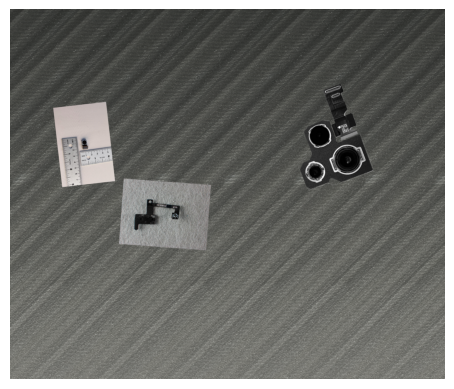

In [ ]:
distraction_images = [os.path.join(DISTRACTIONS_DIR, f) for f in os.listdir(DISTRACTIONS_DIR) if f.endswith('.png') or f.endswith('.jpg')]
def add_random_distractions(img):
    """
    Draws a random number of randomly scaled and rotated distractions on the image.
    """
    num_distractions = np.random.randint(1, 5)
    for _ in range(num_distractions):
        if img.max() <= 1:
            img = (255 * img).astype(np.uint8)
        distraction = np.random.choice(distraction_images)
        distraction_img = plt.imread(distraction)
        if distraction_img.max() <= 1:
            distraction_img = (255 * distraction_img).astype(np.uint8)
        
        # Randomly scale and rotate the distraction
        size = np.random.uniform(0.05, 0.8) * min(img.shape[0], img.shape[1])
        scale = size / min(distraction_img.shape[0], distraction_img.shape[1])
        angle = np.random.uniform(0, 360)
        
        # Randomly position the distraction
        x = int(np.random.rand() * (img.shape[1] - size))
        y = int(np.random.rand() * (img.shape[0] - size))
        
        # Insert the distraction into the image
        img = insert_image(img, distraction_img, x, y, angle, scale)[0]
    return img

bg_with_distractions = add_random_distractions(bg)
plt.imshow(bg_with_distractions)
plt.axis('off')
plt.show()

In [ ]:
test_pcb_images = [os.path.join(PCB_DIR, f) for f in ['s11_front.png', 's14_front.png', 's15_front.png']]
pcb_images = [os.path.join(PCB_DIR, f) for f in os.listdir(PCB_DIR) if f.endswith('.png') or f.endswith('.jpg')]
pcb_images = [img for img in pcb_images if img not in test_pcb_images]
np.random.shuffle(pcb_images)
train_pcb_images = pcb_images[:int(len(pcb_images) * 0.8)]
val_pcb_images = pcb_images[int(len(pcb_images) * 0.8):]
print(f"Train PCB images: {len(train_pcb_images)}")
print(f"Validation PCB images: {len(val_pcb_images)}")

Train PCB images: 212
Validation PCB images: 54


## Orient Object Detection

0 0.474889 0.456884 0.577917 0.496014 0.454210 0.809058 0.351551 0.769928



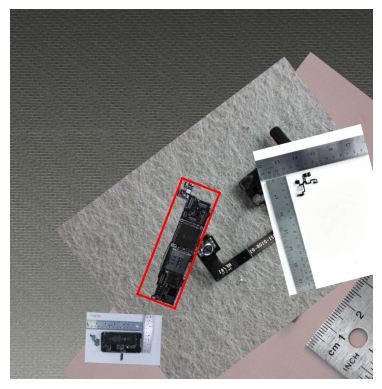

In [ ]:
def create_labeled_sample(pcb_img):
    bg = get_random_background()
    bg_with_distractions = add_random_distractions(bg)

    # Randomly scale and rotate the PCB image, make sure it is always visible
    size = np.random.uniform(0.2, 0.8) * min(bg_with_distractions.shape[0], bg_with_distractions.shape[1])
    scale = size / max(pcb_img.shape[0], pcb_img.shape[1])
    angle = np.random.uniform(0, 360)
    x = int(np.random.rand() * (bg_with_distractions.shape[1] - size))
    y = int(np.random.rand() * (bg_with_distractions.shape[0] - size))
    augmented_img, bounding_box = insert_image(bg_with_distractions, pcb_img, x, y, angle, scale)

    # label format is "class_index x1 y1 x2 y2 x3 y3 x4 y4"
    x1, y1, x2, y2, x3, y3, x4, y4 = bounding_box
    x1 /= augmented_img.shape[1]
    y1 /= augmented_img.shape[0]
    x2 /= augmented_img.shape[1]
    y2 /= augmented_img.shape[0]
    x3 /= augmented_img.shape[1]
    y3 /= augmented_img.shape[0]
    x4 /= augmented_img.shape[1]
    y4 /= augmented_img.shape[0]
    label = f"0 {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}\n"

    return augmented_img, label, (x1, y1, x2, y2, x3, y3, x4, y4)

augmented_img, label, (x1, y1, x2, y2, x3, y3, x4, y4) = create_labeled_sample(plt.imread(train_pcb_images[0]))
print(label)

plt.imshow(augmented_img)
plt.axis('off')

# Draw the bounding box
plt.plot([x1 * augmented_img.shape[1], x2 * augmented_img.shape[1]], [y1 * augmented_img.shape[0], y2 * augmented_img.shape[0]], 'r-')
plt.plot([x2 * augmented_img.shape[1], x3 * augmented_img.shape[1]], [y2 * augmented_img.shape[0], y3 * augmented_img.shape[0]], 'r-')
plt.plot([x3 * augmented_img.shape[1], x4 * augmented_img.shape[1]], [y3 * augmented_img.shape[0], y4 * augmented_img.shape[0]], 'r-')
plt.plot([x4 * augmented_img.shape[1], x1 * augmented_img.shape[1]], [y4 * augmented_img.shape[0], y1 * augmented_img.shape[0]], 'r-')

plt.show()

In [296]:
TRAIN_IMG_DIR = os.path.join(AUGMENTED_OBB_DIR, 'images', 'train')
TRAIN_LABEL_DIR = os.path.join(AUGMENTED_OBB_DIR, 'labels', 'train')
UPSCALE_FACTOR = 5

for image_path in train_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, label, (x1, y1, x2, y2, x3, y3, x4, y4) = create_labeled_sample(pcb_img)
        plt.imsave(os.path.join(TRAIN_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        with open(os.path.join(TRAIN_LABEL_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.txt"), 'w') as f:
            f.write(label)

In [297]:
VAL_IMG_DIR = os.path.join(AUGMENTED_OBB_DIR, 'images', 'val')
VAL_LABEL_DIR = os.path.join(AUGMENTED_OBB_DIR, 'labels', 'val')
UPSCALE_FACTOR = 5

for image_path in val_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, label, (x1, y1, x2, y2, x3, y3, x4, y4) = create_labeled_sample(pcb_img)
        plt.imsave(os.path.join(VAL_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        with open(os.path.join(VAL_LABEL_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.txt"), 'w') as f:
            f.write(label)

/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in divide
  Rotates an image by a given angle with padding and transparent background.
/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in cast
  Rotates an image by a given angle with padding and transparent background.


In [299]:
TEST_IMG_DIR = os.path.join(AUGMENTED_OBB_DIR, 'images', 'test')
TEST_LABEL_DIR = os.path.join(AUGMENTED_OBB_DIR, 'labels', 'test')
UPSCALE_FACTOR = 10

for image_path in test_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, label, (x1, y1, x2, y2, x3, y3, x4, y4) = create_labeled_sample(pcb_img)
        plt.imsave(os.path.join(TEST_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        with open(os.path.join(TEST_LABEL_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.txt"), 'w') as f:
            f.write(label)

/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in divide
  Rotates an image by a given angle with padding and transparent background.
/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in cast
  Rotates an image by a given angle with padding and transparent background.


In [300]:
FCC_TEST_IMG_DIR = os.path.join('..', '.data', 'FCC', '153x67mm')
test_fcc_pcb_images = [os.path.join(FCC_TEST_IMG_DIR, f) for f in os.listdir(FCC_TEST_IMG_DIR) if f.endswith('.png') or f.endswith('.jpg')]
print(f"Test PCB images: {len(test_fcc_pcb_images)}")

Test PCB images: 5


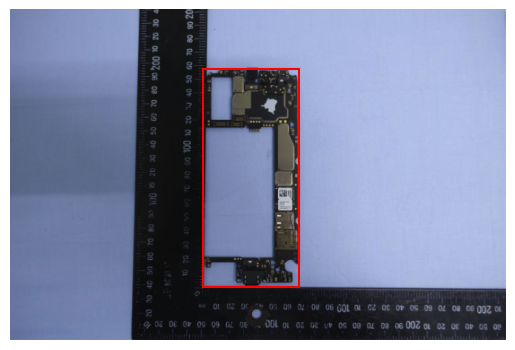

In [335]:
ix = 4
img_path = test_fcc_pcb_images[ix]
img = plt.imread(img_path)

if ix == 0:
    x, y = 240, 100
    w, h = 115, 270
elif ix == 1:
    x, y = 270, 80
    w, h = 125, 290
elif ix == 2:
    x, y = 285, 60
    w, h = 135, 310
elif ix == 3:
    x, y = 250, 70
    w, h = 130, 305
elif ix == 4:
    x, y = 260, 80
    w, h = 130, 295
else:
    raise ValueError("Invalid index")

x1, y1, x2, y2, x3, y3, x4, y4 = x, y, x + w, y, x + w, y + h, x, y + h
x1, y1 = x1 / img.shape[1], y1 / img.shape[0]
x2, y2 = x2 / img.shape[1], y2 / img.shape[0]
x3, y3 = x3 / img.shape[1], y3 / img.shape[0]
x4, y4 = x4 / img.shape[1], y4 / img.shape[0]

plt.imshow(img)
plt.axis('off')

# Draw the bounding box
plt.plot([x1 * img.shape[1], x2 * img.shape[1]], [y1 * img.shape[0], y2 * img.shape[0]], 'r-')
plt.plot([x2 * img.shape[1], x3 * img.shape[1]], [y2 * img.shape[0], y3 * img.shape[0]], 'r-')
plt.plot([x3 * img.shape[1], x4 * img.shape[1]], [y3 * img.shape[0], y4 * img.shape[0]], 'r-')
plt.plot([x4 * img.shape[1], x1 * img.shape[1]], [y4 * img.shape[0], y1 * img.shape[0]], 'r-')

plt.show()

plt.imsave(os.path.join(TEST_IMG_DIR, f"FCC_test_{ix}.png"), img)
with open(os.path.join(TEST_LABEL_DIR, f"FCC_test_{ix}.txt"), 'w') as f:
    f.write(f"0 {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}\n")

## Segmentation

In [ ]:
import cv2
from ultralytics.data.converter import convert_segment_masks_to_yolo_seg

/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in divide
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)
/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in cast
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)


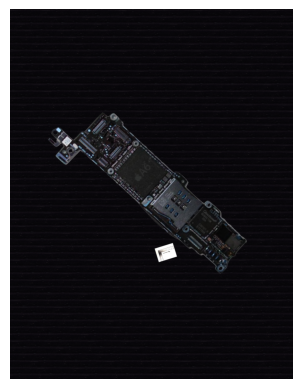

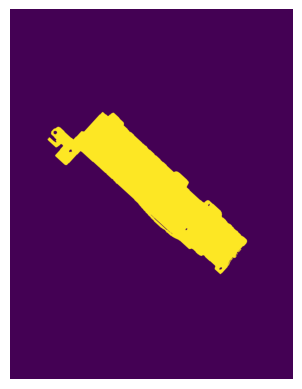

In [353]:
def create_sample_with_mask(pcb_img):
    bg = get_random_background()
    bg_with_distractions = add_random_distractions(bg)


    # Randomly scale and rotate the PCB image, make sure it is always visible
    size = np.random.uniform(0.2, 0.8) * min(bg_with_distractions.shape[0], bg_with_distractions.shape[1])
    scale = size / max(pcb_img.shape[0], pcb_img.shape[1])
    angle = np.random.uniform(0, 360)
    x = int(np.random.rand() * (bg_with_distractions.shape[1] - size))
    y = int(np.random.rand() * (bg_with_distractions.shape[0] - size))
    augmented_img, bounding_box = insert_image(bg_with_distractions, pcb_img, x, y, angle, scale)

    # Create the mask
    mask = np.zeros((bg_with_distractions.shape[0], bg_with_distractions.shape[1], 4), dtype=np.uint8)
    mask_overlay = np.zeros((pcb_img.shape[0], pcb_img.shape[1], 4), dtype=np.uint8)
    mask_overlay[pcb_img[:, :, 3] > 0] = (255, 255, 255, 255)
    augmented_mask, mask_bbox = insert_image(mask, mask_overlay, x, y, angle, scale)
    binary_mask = np.zeros((augmented_mask.shape[0], augmented_mask.shape[1]), dtype=np.uint8)
    binary_mask[augmented_mask[:, :, 3] > 0] = 1

    assert bounding_box == mask_bbox, "Bounding box and mask bounding box do not match"

    return augmented_img, binary_mask

pcb_img = plt.imread(train_pcb_images[0])
if pcb_img.max() <= 1:
    pcb_img = (255 * pcb_img).astype(np.uint8)

augmented_img, binary_mask = create_sample_with_mask(pcb_img)

plt.imshow(augmented_img)
plt.axis('off')
plt.show()
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

In [373]:
SEG_TRAIN_IMG_DIR = os.path.join(AUGMENTED_SEG_DIR, 'images', 'train')
SEG_TRAIN_LABEL_DIR = os.path.join(AUGMENTED_SEG_DIR, 'labels', 'train')
SEG_TRAIN_MASK_DIR = os.path.join(AUGMENTED_SEG_DIR, 'masks', 'train')
UPSCALE_FACTOR = 5

for image_path in train_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, binary_mask = create_sample_with_mask(pcb_img)
        plt.imsave(os.path.join(SEG_TRAIN_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        cv2.imwrite(os.path.join(SEG_TRAIN_MASK_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), binary_mask)

/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in divide
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)
/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in cast
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)


In [374]:
convert_segment_masks_to_yolo_seg(masks_dir=SEG_TRAIN_MASK_DIR, output_dir=SEG_TRAIN_LABEL_DIR, classes=1)
clear_output()

In [375]:
SEG_VAL_IMG_DIR = os.path.join(AUGMENTED_SEG_DIR, 'images', 'val')
SEG_VAL_LABEL_DIR = os.path.join(AUGMENTED_SEG_DIR, 'labels', 'val')
SEG_VAL_MASK_DIR = os.path.join(AUGMENTED_SEG_DIR, 'masks', 'val')
UPSCALE_FACTOR = 5

for image_path in val_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, binary_mask = create_sample_with_mask(pcb_img)
        plt.imsave(os.path.join(SEG_VAL_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        cv2.imwrite(os.path.join(SEG_VAL_MASK_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), binary_mask)

/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in divide
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)
/Users/alex/Desktop/CS/ML/PCB-Detection/notebooks/../scripts/augment.py:148: RuntimeWarning: invalid value encountered in cast
  bg_region[:, :, c] = (overlay_rgb[:, :, c] * alpha + bg_region[:, :, c] * (1 - alpha) * bg_alpha) / (alpha + (1 - alpha) * bg_alpha)


In [376]:
convert_segment_masks_to_yolo_seg(masks_dir=SEG_VAL_MASK_DIR, output_dir=SEG_VAL_LABEL_DIR, classes=1)
clear_output()

In [377]:
SEG_TEST_IMG_DIR = os.path.join(AUGMENTED_SEG_DIR, 'images', 'test')
SEG_TEST_LABEL_DIR = os.path.join(AUGMENTED_SEG_DIR, 'labels', 'test')
SEG_TEST_MASK_DIR = os.path.join(AUGMENTED_SEG_DIR, 'masks', 'test')
UPSCALE_FACTOR = 5

for image_path in test_pcb_images:
    pcb_img = plt.imread(image_path)
    if pcb_img.max() <= 1:
        pcb_img = (255 * pcb_img).astype(np.uint8)

    for i in range(UPSCALE_FACTOR):
        augmented_img, binary_mask = create_sample_with_mask(pcb_img)
        plt.imsave(os.path.join(SEG_TEST_IMG_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), augmented_img)
        cv2.imwrite(os.path.join(SEG_TEST_MASK_DIR, f"{os.path.basename(image_path).split('.')[0]}_{i}.png"), binary_mask)

In [378]:
convert_segment_masks_to_yolo_seg(masks_dir=SEG_TEST_MASK_DIR, output_dir=SEG_TEST_LABEL_DIR, classes=1)
clear_output()